In [1]:
from PyQt5.QtWidgets import QDialog,QApplication,QFileDialog
from PyQt5.QtCore import *
from PyQt5 import QtCore, QtGui, QtWidgets
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from PyQt5.QtGui import QIntValidator
import datetime
from datetime import datetime, timedelta
from PyQt5.QtGui import QImage, QPixmap
from PyQt5.QtWidgets import QMainWindow, QApplication, QGraphicsScene, QGraphicsPixmapItem
from PyQt5 import QtCore, QtGui, QtWidgets
now_output_time = str(datetime.now().strftime('%Y-%m-%d %H-%M-%S'))
import os
from PyQt5 import QtCore, QtGui, QtWidgets

colorTab_More4 = ['#e8a5eb', '#facc9e', '#e8e948', '#1bb763',
                       '#25f2f3', '#1db3ea', '#d1aef8', '#c8c92c',
                       '#f32020', '#fd9b09', '#406386', '#24a1a1',
                       '#1515f8', '#959697', '#744a20', '#7b45a5']

class Ui_MainWindow(QtWidgets.QWidget):
    def browsefile(self):
        if self.Start_time.text() == "" or self.End_time.text() == "":
            QtWidgets.QMessageBox.critical(self, u"存取失敗", u"請輸入Time of background", buttons=QtWidgets.QMessageBox.Ok, defaultButton=QtWidgets.QMessageBox.Ok)
        elif (int(self.Start_time.text()) > int(self.End_time.text())):
            print("BAD")
        else:
            if os.path.isdir("CT_image"):
                print("資料夾存在。")
            else:
                print("資料夾不存在。")
                os.mkdir("CT_image")
            self.fname = QFileDialog.getOpenFileName(self, '開啟csv檔案', 'C:\Program Files (x86)', 'csv files (*.csv)')
            self.Input_file.setText(self.fname[0])

            self.df_raw = pd.read_csv(self.fname[0])
            self.df_ifc = pd.read_csv("cali_factor.csv")
            self.df_normalization = self.df_raw.copy()
            self.get_accumulation_time()
            self.normalize()
            threshold_value = self.get_ct_threshold()
            self.Ct_value = self.get_ct_value(threshold_value)
            print(self.Ct_value)
            self.lineEdit_well_1.setText(str(self.Ct_value[0]))
            self.lineEdit_well_2.setText(str(self.Ct_value[1]))
            self.lineEdit_well_3.setText(str(self.Ct_value[2]))
            self.lineEdit_well_4.setText(str(self.Ct_value[3]))
            self.lineEdit_well_5.setText(str(self.Ct_value[4]))
            self.lineEdit_well_6.setText(str(self.Ct_value[5]))
            self.lineEdit_well_7.setText(str(self.Ct_value[6]))
            self.lineEdit_well_8.setText(str(self.Ct_value[7]))
            self.lineEdit_well_9.setText(str(self.Ct_value[8]))
            self.lineEdit_well_10.setText(str(self.Ct_value[9]))
            self.lineEdit_well_11.setText(str(self.Ct_value[10]))
            self.lineEdit_well_12.setText(str(self.Ct_value[11]))
            self.lineEdit_well_13.setText(str(self.Ct_value[12]))
            self.lineEdit_well_14.setText(str(self.Ct_value[13]))
            self.lineEdit_well_15.setText(str(self.Ct_value[14]))
            self.lineEdit_well_16.setText(str(self.Ct_value[15]))
            self.well_1_data = []
            self.well_2_data = []
            self.well_3_data = []
            self.well_4_data = []
            self.well_5_data = []
            self.well_6_data = []
            self.well_7_data = []
            self.well_8_data = []
            self.well_9_data = []
            self.well_10_data = []
            self.well_11_data = []
            self.well_12_data = []
            self.well_13_data = []
            self.well_14_data = []
            self.well_15_data = []
            self.well_16_data = []
            self.time_array = []
            #well1
            for i in range(0, len(self.df_raw.index), 1):
                self.well_1_data.append((self.df_raw.loc[i, 'well_1'] - self.well_baseline[0]) / self.well_baseline[0])
            #well2
            for i in range(0, len(self.df_raw.index), 1):
                self.well_2_data.append((self.df_raw.loc[i, 'well_2'] - self.well_baseline[1]) / self.well_baseline[1])
            #well3
            for i in range(0, len(self.df_raw.index), 1):
                self.well_3_data.append((self.df_raw.loc[i, 'well_3'] - self.well_baseline[2]) / self.well_baseline[2])
            #well4
            for i in range(0, len(self.df_raw.index), 1):
                self.well_4_data.append((self.df_raw.loc[i, 'well_4'] - self.well_baseline[3]) / self.well_baseline[3])
            #well5
            for i in range(0, len(self.df_raw.index), 1):
                self.well_5_data.append((self.df_raw.loc[i, 'well_5'] - self.well_baseline[4]) / self.well_baseline[4])
            # well6
            for i in range(0, len(self.df_raw.index), 1):
                self.well_6_data.append((self.df_raw.loc[i, 'well_6'] - self.well_baseline[5]) / self.well_baseline[5])
            # well7
            for i in range(0, len(self.df_raw.index), 1):
                self.well_7_data.append((self.df_raw.loc[i, 'well_7'] - self.well_baseline[6]) / self.well_baseline[6])
            # well8
            for i in range(0, len(self.df_raw.index), 1):
                self.well_8_data.append((self.df_raw.loc[i, 'well_8'] - self.well_baseline[7]) / self.well_baseline[7])
            # well9
            for i in range(0, len(self.df_raw.index), 1):
                self.well_9_data.append((self.df_raw.loc[i, 'well_9'] - self.well_baseline[8]) / self.well_baseline[8])
            # well10
            for i in range(0, len(self.df_raw.index), 1):
                self.well_10_data.append((self.df_raw.loc[i, 'well_10'] - self.well_baseline[9]) / self.well_baseline[9])
            # # well11
            for i in range(0, len(self.df_raw.index), 1):
                self.well_11_data.append((self.df_raw.loc[i, 'well_11'] - self.well_baseline[10]) / self.well_baseline[10])
            # # well12
            for i in range(0, len(self.df_raw.index), 1):
                self.well_12_data.append((self.df_raw.loc[i, 'well_12'] - self.well_baseline[11]) / self.well_baseline[11])
            # # well13
            for i in range(0, len(self.df_raw.index), 1):
                self.well_13_data.append((self.df_raw.loc[i, 'well_13'] - self.well_baseline[12]) / self.well_baseline[12])
            # well14
            for i in range(0, len(self.df_raw.index), 1):
                self.well_14_data.append((self.df_raw.loc[i, 'well_14'] - self.well_baseline[13]) / self.well_baseline[13])
            # well15
            for i in range(0, len(self.df_raw.index), 1):
                self.well_15_data.append((self.df_raw.loc[i, 'well_15'] - self.well_baseline[14]) / self.well_baseline[14])
            # wel16
            for i in range(0, len(self.df_raw.index), 1):
                self.well_16_data.append((self.df_raw.loc[i, 'well_16'] - self.well_baseline[15]) / self.well_baseline[15])

            for j in range(0, len(self.df_raw.index),1):
                self.time_array.append(j/2)

            plt.figure(figsize=(6,4.5),dpi=100,linewidth = 3)
            plt.plot(self.time_array,self.well_1_data,'-',color = colorTab_More4[0], label="well_1")    #紅
            plt.plot(self.time_array,self.well_2_data,'-',color = colorTab_More4[1], label="well_2") #澄
            plt.plot(self.time_array,self.well_3_data,'-',color = colorTab_More4[2], label="well_3") #黃
            plt.plot(self.time_array,self.well_4_data,'-',color = colorTab_More4[3], label="well_4")  #綠
            plt.plot(self.time_array,self.well_5_data,'-',color = colorTab_More4[4], label="well_5")#藍
            plt.plot(self.time_array,self.well_6_data,'-',color = colorTab_More4[5], label="well_6")      #靛
            plt.plot(self.time_array,self.well_7_data,'-',color = colorTab_More4[6], label="well_7") #紫
            plt.plot(self.time_array,self.well_8_data,'-',color = colorTab_More4[7], label="well_8")      #黑
            plt.plot(self.time_array,self.well_9_data, '-', color= colorTab_More4[8], label="well_9")  # 紅
            plt.plot(self.time_array,self.well_10_data, '-', color= colorTab_More4[9], label="well_10")  # 澄
            plt.plot(self.time_array,self.well_11_data, '-', color= colorTab_More4[10], label="well_11")  # 黃
            plt.plot(self.time_array,self.well_12_data, '-', color= colorTab_More4[11], label="well_12")  # 綠
            plt.plot(self.time_array,self.well_13_data, '-', color= colorTab_More4[12], label="well_13")  # 藍
            plt.plot(self.time_array,self.well_14_data, '-', color= colorTab_More4[13], label="well_14")  # 靛
            plt.plot(self.time_array,self.well_15_data, '-', color= colorTab_More4[14], label="well_15")  # 紫
            plt.plot(self.time_array,self.well_16_data, '-', color= colorTab_More4[15], label="well_16")  # 黑
            plt.ylim(0, 3)
            plt.title("Amplification curve")
            plt.xlabel('Time (min)')  # x軸說明文字
            plt.ylabel('Fluorescence signal intensity(a.u.)')  # y軸說明文字
            plt.legend(loc="best", fontsize=7.5)
            plt.savefig('CT_image/CT.jpg')
            plt.show()
            self.displayphoto()

    def displayphoto(self):
        self.img = cv.imread('CT_image/CT.jpg')
        self.img = cv.cvtColor(self.img, cv.COLOR_BGR2RGB)
        x = self.img.shape[1]
        y = self.img.shape[0]
        frame = QImage(self.img, x, y, x * 3, QImage.Format_RGB888)
        self.pix = QPixmap.fromImage(frame)
        self.item = QGraphicsPixmapItem(self.pix)
        self.scene = QGraphicsScene()
        self.scene.addItem(self.item)
        self.CT_chart.setScene(self.scene)

    def get_accumulation_time(self):
        df_time = self.df_normalization['time']
        time_ori = datetime.strptime(df_time[0], "%H:%M:%S")
        time_delta = []
        for time in df_time:
            time_now = datetime.strptime(time, "%H:%M:%S")
            time_delta.append((time_now - time_ori).seconds / 60)
        self.df_normalization.insert(1, column="accumulation", value=time_delta)

    def get_StdDev_and_Avg(self):
        StdDev = []
        Avg = []
        for i in range(0, 16):
            df_current_well = self.df_normalization[f'well_{i + 1}']
            StdDev.append(df_current_well[int(self.Start_time.text()) *2 :int(self.End_time.text())*2].std())
            Avg.append(df_current_well[int(self.Start_time.text()) *2 :int(self.End_time.text())*2].mean())
        return StdDev, Avg

    def normalize(self):
        self.well_baseline =[]
        for i in range(0, 16):
            df_current_well = self.df_raw[f'well_{i + 1}']
            df_current_ifc = self.df_ifc[f'well{i + 1}']
            self.baseline = df_current_well[int(self.Start_time.text()) *2 :int(self.End_time.text())*2].mean()
            self.df_normalization[f'well{i + 1}'] = (self.df_raw[f'well_{i + 1}'] - self.baseline) / self.baseline  # normalized = (IF(t)-IF(b))/IFc
            self.well_baseline.append(self.baseline)
        print(self.well_baseline)



    def get_ct_threshold(self):
        threshold_value = []
        StdDev, Avg = self.get_StdDev_and_Avg()
        for i in range(0, 16):
            threshold_value.append(10 * StdDev[i] + Avg[i])
            # print(f"Well {i + 1}: StdDev is {StdDev[i]}, Avg is {Avg[i]}")
        return threshold_value

    def get_ct_value(self,threshold_value):
        Ct_value = []
        for i in range(0, 16):
            df_current_well = self.df_normalization[f'well_{i + 1}']
            df_accumulation = self.df_normalization['accumulation']
            # print("\n")
            # print(df_current_well)
            # print(f"Threshold value: {threshold_value[i]}")
            try:
                for j, row in enumerate(df_current_well):
                    if row >= threshold_value[i]:
                        print(f"row: {row}")
                        thres_lower = df_current_well[j - 1]
                        thres_upper = df_current_well[j]
                        acc_time_lower = df_accumulation[j - 1]
                        acc_time_upper = df_accumulation[j + 1]

                        # linear regression
                        x2 = acc_time_upper
                        y2 = thres_upper
                        x1 = acc_time_lower
                        y1 = thres_lower
                        y = threshold_value[i]
                        x = (x2 - x1) * (y - y1) / (y2 - y1) + x1

                        Ct_value.append(round(x, 2))
                        print(f"Ct of well_{i + 1} is {round(x, 2)}")
                        break

                    # if there is no Ct_value availible
                    elif j == len(df_current_well) - 1:
                        Ct_value.append(99.99)
                        print("Ct value is not available")
            except Exception as e:
                print(e)
                Ct_value.append(99.99)
                print("Ct value is not available")

        return Ct_value

    def save_file(self):
        if self.Input_file.text() == "":
            QtWidgets.QMessageBox.critical(self, u"存取失敗", u"未開啟csv檔案", buttons=QtWidgets.QMessageBox.Ok,
                defaultButton=QtWidgets.QMessageBox.Ok)
        else:
            QtWidgets.QMessageBox.information(self, u"存取成功", u"已成功另存Excel檔案", buttons=QtWidgets.QMessageBox.Ok,
                defaultButton=QtWidgets.QMessageBox.Ok)
            self.save_excel =pd.DataFrame({"well_1":[self.Ct_value[0]],"well_2":[self.Ct_value[1]],"well_3":[self.Ct_value[2]],"well_4":[self.Ct_value[3]],
                                   "well_5":[self.Ct_value[4]],"well_6":[self.Ct_value[5]],"well_7":[self.Ct_value[6]],"well_8":[self.Ct_value[7]],
                                   "well_9":[self.Ct_value[8]],"well_10":[self.Ct_value[9]],"well_11":[self.Ct_value[10]],"well_12":[self.Ct_value[11]],
                                   "well_13":[self.Ct_value[12]],"well_14":[self.Ct_value[13]],"well_15":[self.Ct_value[14]],"well_16":[self.Ct_value[15]]}
        ,index=["CT_Value"])
            self.save_excel.to_excel('./result/CT_Chart' + now_output_time+"output.xlsx", encoding="utf_8_sig")

    def clean_log(self):
        self.Input_file.setText("")
        self.lineEdit_well_1.setText("")
        self.lineEdit_well_2.setText("")
        self.lineEdit_well_3.setText("")
        self.lineEdit_well_4.setText("")
        self.lineEdit_well_5.setText("")
        self.lineEdit_well_6.setText("")
        self.lineEdit_well_7.setText("")
        self.lineEdit_well_8.setText("")
        self.lineEdit_well_9.setText("")
        self.lineEdit_well_10.setText("")
        self.lineEdit_well_11.setText("")
        self.lineEdit_well_12.setText("")
        self.lineEdit_well_13.setText("")
        self.lineEdit_well_14.setText("")
        self.lineEdit_well_15.setText("")
        self.lineEdit_well_16.setText("")
        self.Start_time.setText("")
        self.End_time.setText("")
        self.Input_N.setText("")

    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(1011, 571)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setObjectName("centralwidget")
        self.Input_file = QtWidgets.QLineEdit(self.centralwidget)
        self.Input_file.setGeometry(QtCore.QRect(10, 18, 641, 31))
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.Input_file.setFont(font)
        self.Input_file.setObjectName("Input_file")
        self.CT_chart = QtWidgets.QGraphicsView(self.centralwidget)
        self.CT_chart.setGeometry(QtCore.QRect(10, 66, 641, 481))
        self.CT_chart.setObjectName("CT_chart")
        self.label_3 = QtWidgets.QLabel(self.centralwidget)
        self.label_3.setGeometry(QtCore.QRect(20, 462, 111, 16))
        font = QtGui.QFont()
        font.setPointSize(10)
        font.setBold(True)
        font.setWeight(75)
        self.label_3.setFont(font)
        self.label_3.setText("")
        self.label_3.setObjectName("label_3")
        self.layoutWidget = QtWidgets.QWidget(self.centralwidget)
        self.layoutWidget.setGeometry(QtCore.QRect(660, 72, 341, 69))
        self.layoutWidget.setObjectName("layoutWidget")
        self.Input_Time = QtWidgets.QGridLayout(self.layoutWidget)
        self.Input_Time.setContentsMargins(0, 0, 0, 0)
        self.Input_Time.setObjectName("Input_Time")
        self.label_Timeofbackground = QtWidgets.QLabel(self.layoutWidget)
        font = QtGui.QFont()
        font.setPointSize(15)
        font.setBold(True)
        font.setWeight(75)
        self.label_Timeofbackground.setFont(font)
        self.label_Timeofbackground.setAlignment(QtCore.Qt.AlignCenter)
        self.label_Timeofbackground.setObjectName("label_Timeofbackground")
        self.Input_Time.addWidget(self.label_Timeofbackground, 0, 0, 1, 3)
        self.Start_time = QtWidgets.QLineEdit(self.layoutWidget)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.Start_time.setFont(font)
        self.Start_time.setAlignment(QtCore.Qt.AlignCenter)
        self.Start_time.setObjectName("Start_time")
        self.Input_Time.addWidget(self.Start_time, 1, 0, 1, 1)
        self.label_7 = QtWidgets.QLabel(self.layoutWidget)
        font = QtGui.QFont()
        font.setPointSize(15)
        font.setBold(True)
        font.setWeight(75)
        self.label_7.setFont(font)
        self.label_7.setAlignment(QtCore.Qt.AlignCenter)
        self.label_7.setObjectName("label_7")
        self.Input_Time.addWidget(self.label_7, 1, 1, 1, 1)
        self.End_time = QtWidgets.QLineEdit(self.layoutWidget)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.End_time.setFont(font)
        self.End_time.setAlignment(QtCore.Qt.AlignCenter)
        self.End_time.setObjectName("End_time")
        self.Input_Time.addWidget(self.End_time, 1, 2, 1, 1)
        self.layoutWidget1 = QtWidgets.QWidget(self.centralwidget)
        self.layoutWidget1.setGeometry(QtCore.QRect(660, 144, 341, 69))
        self.layoutWidget1.setObjectName("layoutWidget1")
        self.ThresholdBlock = QtWidgets.QGridLayout(self.layoutWidget1)
        self.ThresholdBlock.setContentsMargins(0, 0, 0, 0)
        self.ThresholdBlock.setObjectName("ThresholdBlock")
        self.label_N = QtWidgets.QLabel(self.layoutWidget1)
        font = QtGui.QFont()
        font.setPointSize(15)
        font.setBold(True)
        font.setWeight(75)
        self.label_N.setFont(font)
        self.label_N.setAlignment(QtCore.Qt.AlignCenter)
        self.label_N.setObjectName("label_N")
        self.ThresholdBlock.addWidget(self.label_N, 1, 0, 1, 1)
        self.Input_N = QtWidgets.QLineEdit(self.layoutWidget1)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.Input_N.setFont(font)
        self.Input_N.setAlignment(QtCore.Qt.AlignCenter)
        self.Input_N.setObjectName("Input_N")
        self.ThresholdBlock.addWidget(self.Input_N, 1, 1, 1, 1)
        self.label_Threshold = QtWidgets.QLabel(self.layoutWidget1)
        font = QtGui.QFont()
        font.setPointSize(15)
        font.setBold(True)
        font.setWeight(75)
        self.label_Threshold.setFont(font)
        self.label_Threshold.setAlignment(QtCore.Qt.AlignCenter)
        self.label_Threshold.setObjectName("label_Threshold")
        self.ThresholdBlock.addWidget(self.label_Threshold, 0, 0, 1, 2)
        self.layoutWidget2 = QtWidgets.QWidget(self.centralwidget)
        self.layoutWidget2.setGeometry(QtCore.QRect(660, 0, 341, 67))
        self.layoutWidget2.setObjectName("layoutWidget2")
        self.ButtonBlcok = QtWidgets.QGridLayout(self.layoutWidget2)
        self.ButtonBlcok.setContentsMargins(0, 0, 0, 0)
        self.ButtonBlcok.setObjectName("ButtonBlcok")
        self.btn_openfile = QtWidgets.QPushButton(self.layoutWidget2)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.btn_openfile.setFont(font)
        self.btn_openfile.setObjectName("btn_openfile")
        self.ButtonBlcok.addWidget(self.btn_openfile, 0, 0, 1, 1)
        self.btn_savefile = QtWidgets.QPushButton(self.layoutWidget2)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.btn_savefile.setFont(font)
        self.btn_savefile.setObjectName("btn_savefile")
        self.ButtonBlcok.addWidget(self.btn_savefile, 0, 1, 1, 1)
        self.btn_clean = QtWidgets.QPushButton(self.layoutWidget2)
        font = QtGui.QFont()
        font.setFamily("MS UI Gothic")
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.btn_clean.setFont(font)
        self.btn_clean.setObjectName("btn_clean")
        self.ButtonBlcok.addWidget(self.btn_clean, 0, 2, 1, 1)
        self.layoutWidget3 = QtWidgets.QWidget(self.centralwidget)
        self.layoutWidget3.setGeometry(QtCore.QRect(660, 258, 341, 291))
        self.layoutWidget3.setObjectName("layoutWidget3")
        self.gridLayout = QtWidgets.QGridLayout(self.layoutWidget3)
        self.gridLayout.setContentsMargins(0, 0, 0, 0)
        self.gridLayout.setObjectName("gridLayout")
        self.lineEdit_well_11 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_11.setFont(font)
        self.lineEdit_well_11.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_11.setObjectName("lineEdit_well_11")
        self.gridLayout.addWidget(self.lineEdit_well_11, 2, 3, 1, 1)
        self.lineEdit_well_15 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_15.setFont(font)
        self.lineEdit_well_15.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_15.setObjectName("lineEdit_well_15")
        self.gridLayout.addWidget(self.lineEdit_well_15, 6, 3, 1, 1)
        self.label_well2 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well2.setFont(font)
        self.label_well2.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well2.setObjectName("label_well2")
        self.gridLayout.addWidget(self.label_well2, 1, 0, 1, 1)
        self.lineEdit_well_10 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_10.setFont(font)
        self.lineEdit_well_10.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_10.setObjectName("lineEdit_well_10")
        self.gridLayout.addWidget(self.lineEdit_well_10, 1, 3, 1, 1)
        self.lineEdit_well_5 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_5.setFont(font)
        self.lineEdit_well_5.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_5.setObjectName("lineEdit_well_5")
        self.gridLayout.addWidget(self.lineEdit_well_5, 4, 1, 1, 1)
        self.lineEdit_well_3 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_3.setFont(font)
        self.lineEdit_well_3.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_3.setObjectName("lineEdit_well_3")
        self.gridLayout.addWidget(self.lineEdit_well_3, 2, 1, 1, 1)
        self.lineEdit_well_12 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_12.setFont(font)
        self.lineEdit_well_12.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_12.setObjectName("lineEdit_well_12")
        self.gridLayout.addWidget(self.lineEdit_well_12, 3, 3, 1, 1)
        self.lineEdit_well_4 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_4.setFont(font)
        self.lineEdit_well_4.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_4.setObjectName("lineEdit_well_4")
        self.gridLayout.addWidget(self.lineEdit_well_4, 3, 1, 1, 1)
        self.lineEdit_well_2 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_2.setFont(font)
        self.lineEdit_well_2.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_2.setObjectName("lineEdit_well_2")
        self.gridLayout.addWidget(self.lineEdit_well_2, 1, 1, 1, 1)
        self.lineEdit_well_6 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_6.setFont(font)
        self.lineEdit_well_6.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_6.setObjectName("lineEdit_well_6")
        self.gridLayout.addWidget(self.lineEdit_well_6, 5, 1, 1, 1)
        self.lineEdit_well_8 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_8.setFont(font)
        self.lineEdit_well_8.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_8.setObjectName("lineEdit_well_8")
        self.gridLayout.addWidget(self.lineEdit_well_8, 7, 1, 1, 1)
        self.label_well12 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well12.setFont(font)
        self.label_well12.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well12.setObjectName("label_well12")
        self.gridLayout.addWidget(self.label_well12, 3, 2, 1, 1)
        self.label_well3 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well3.setFont(font)
        self.label_well3.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well3.setObjectName("label_well3")
        self.gridLayout.addWidget(self.label_well3, 2, 0, 1, 1)
        self.label_well11 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well11.setFont(font)
        self.label_well11.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well11.setObjectName("label_well11")
        self.gridLayout.addWidget(self.label_well11, 2, 2, 1, 1)
        self.lineEdit_well_16 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_16.setFont(font)
        self.lineEdit_well_16.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_16.setObjectName("lineEdit_well_16")
        self.gridLayout.addWidget(self.lineEdit_well_16, 7, 3, 1, 1)
        self.label_well4 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well4.setFont(font)
        self.label_well4.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well4.setObjectName("label_well4")
        self.gridLayout.addWidget(self.label_well4, 3, 0, 1, 1)
        self.lineEdit_well_1 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_1.setFont(font)
        self.lineEdit_well_1.setText("")
        self.lineEdit_well_1.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_1.setObjectName("lineEdit_well_1")
        self.gridLayout.addWidget(self.lineEdit_well_1, 0, 1, 1, 1)
        self.lineEdit_well_9 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_9.setFont(font)
        self.lineEdit_well_9.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_9.setObjectName("lineEdit_well_9")
        self.gridLayout.addWidget(self.lineEdit_well_9, 0, 3, 1, 1)
        self.lineEdit_well_13 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_13.setFont(font)
        self.lineEdit_well_13.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_13.setObjectName("lineEdit_well_13")
        self.gridLayout.addWidget(self.lineEdit_well_13, 4, 3, 1, 1)
        self.label_well9 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well9.setFont(font)
        self.label_well9.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well9.setObjectName("label_well9")
        self.gridLayout.addWidget(self.label_well9, 0, 2, 1, 1)
        self.label_well5 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well5.setFont(font)
        self.label_well5.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well5.setObjectName("label_well5")
        self.gridLayout.addWidget(self.label_well5, 4, 0, 1, 1)
        self.label_well1 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well1.setFont(font)
        self.label_well1.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well1.setObjectName("label_well1")
        self.gridLayout.addWidget(self.label_well1, 0, 0, 1, 1)
        self.lineEdit_well_14 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_14.setFont(font)
        self.lineEdit_well_14.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_14.setObjectName("lineEdit_well_14")
        self.gridLayout.addWidget(self.lineEdit_well_14, 5, 3, 1, 1)
        self.label_well10 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well10.setFont(font)
        self.label_well10.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well10.setObjectName("label_well10")
        self.gridLayout.addWidget(self.label_well10, 1, 2, 1, 1)
        self.label_well6 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well6.setFont(font)
        self.label_well6.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well6.setObjectName("label_well6")
        self.gridLayout.addWidget(self.label_well6, 5, 0, 1, 1)
        self.lineEdit_well_7 = QtWidgets.QLineEdit(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        self.lineEdit_well_7.setFont(font)
        self.lineEdit_well_7.setAlignment(QtCore.Qt.AlignCenter)
        self.lineEdit_well_7.setObjectName("lineEdit_well_7")
        self.gridLayout.addWidget(self.lineEdit_well_7, 6, 1, 1, 1)
        self.label_well7 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well7.setFont(font)
        self.label_well7.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well7.setObjectName("label_well7")
        self.gridLayout.addWidget(self.label_well7, 6, 0, 1, 1)
        self.label_well8 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well8.setFont(font)
        self.label_well8.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well8.setObjectName("label_well8")
        self.gridLayout.addWidget(self.label_well8, 7, 0, 1, 1)
        self.label_well13 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well13.setFont(font)
        self.label_well13.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well13.setObjectName("label_well13")
        self.gridLayout.addWidget(self.label_well13, 4, 2, 1, 1)
        self.label_well14 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well14.setFont(font)
        self.label_well14.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well14.setObjectName("label_well14")
        self.gridLayout.addWidget(self.label_well14, 5, 2, 1, 1)
        self.label_well15 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well15.setFont(font)
        self.label_well15.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well15.setObjectName("label_well15")
        self.gridLayout.addWidget(self.label_well15, 6, 2, 1, 1)
        self.label_well16 = QtWidgets.QLabel(self.layoutWidget3)
        font = QtGui.QFont()
        font.setPointSize(12)
        font.setBold(True)
        font.setWeight(75)
        self.label_well16.setFont(font)
        self.label_well16.setAlignment(QtCore.Qt.AlignCenter)
        self.label_well16.setObjectName("label_well16")
        self.gridLayout.addWidget(self.label_well16, 7, 2, 1, 1)
        self.layoutWidget4 = QtWidgets.QWidget(self.centralwidget)
        self.layoutWidget4.setGeometry(QtCore.QRect(660, 216, 341, 32))
        self.layoutWidget4.setObjectName("layoutWidget4")
        self.gridLayout_2 = QtWidgets.QGridLayout(self.layoutWidget4)
        self.gridLayout_2.setContentsMargins(0, 0, 0, 0)
        self.gridLayout_2.setObjectName("gridLayout_2")
        self.label_Threshold_2 = QtWidgets.QLabel(self.layoutWidget4)
        font = QtGui.QFont()
        font.setPointSize(15)
        font.setBold(True)
        font.setWeight(75)
        self.label_Threshold_2.setFont(font)
        self.label_Threshold_2.setAlignment(QtCore.Qt.AlignCenter)
        self.label_Threshold_2.setObjectName("label_Threshold_2")
        self.gridLayout_2.addWidget(self.label_Threshold_2, 0, 0, 1, 1)
        self.label_Threshold_3 = QtWidgets.QLabel(self.layoutWidget4)
        font = QtGui.QFont()
        font.setPointSize(15)
        font.setBold(True)
        font.setWeight(75)
        self.label_Threshold_3.setFont(font)
        self.label_Threshold_3.setAlignment(QtCore.Qt.AlignCenter)
        self.label_Threshold_3.setObjectName("label_Threshold_3")
        self.gridLayout_2.addWidget(self.label_Threshold_3, 0, 1, 1, 1)
        MainWindow.setCentralWidget(self.centralwidget)
        self.retranslateUi(MainWindow)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)

        self.btn_openfile.clicked.connect(self.browsefile)
        self.btn_savefile.clicked.connect(self.save_file)
        self.btn_clean.clicked.connect(self.clean_log)

    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.label_Timeofbackground.setText(_translate("MainWindow", "Time of background (min)"))
        self.label_7.setText(_translate("MainWindow", "~"))
        self.label_N.setText(_translate("MainWindow", "N :"))
        self.label_Threshold.setText(_translate("MainWindow", "Threshold= N  * Std"))
        self.btn_openfile.setText(_translate("MainWindow", "開啟檔案"))
        self.btn_savefile.setText(_translate("MainWindow", "儲存檔案"))
        self.btn_clean.setText(_translate("MainWindow", "清除"))
        self.label_well2.setText(_translate("MainWindow", "well2(A2)"))
        self.label_well12.setText(_translate("MainWindow", "well12(A12)"))
        self.label_well3.setText(_translate("MainWindow", "well3(A3)"))
        self.label_well11.setText(_translate("MainWindow", "well11(A11)"))
        self.label_well4.setText(_translate("MainWindow", "well4(A4)"))
        self.label_well9.setText(_translate("MainWindow", "well9(A9)"))
        self.label_well5.setText(_translate("MainWindow", "well5(A5)"))
        self.label_well1.setText(_translate("MainWindow", "well1(A1)"))
        self.label_well10.setText(_translate("MainWindow", "well10(A10)"))
        self.label_well6.setText(_translate("MainWindow", "well6(A6)"))
        self.label_well7.setText(_translate("MainWindow", "well7(A7)"))
        self.label_well8.setText(_translate("MainWindow", "well8(A8)"))
        self.label_well13.setText(_translate("MainWindow", "well13(A13)"))
        self.label_well14.setText(_translate("MainWindow", "well14(A14)"))
        self.label_well15.setText(_translate("MainWindow", "well15(A15)"))
        self.label_well16.setText(_translate("MainWindow", "well16(A16)"))
        self.label_Threshold_2.setText(_translate("MainWindow", "CT_Value"))
        self.label_Threshold_3.setText(_translate("MainWindow", "CT_Value"))


資料夾存在。
[54.40909090909091, 63.63636363636363, 96.5909090909091, 99.86363636363636, 68.13636363636364, 68.36363636363636, 86.63636363636364, 68.22727272727273, 49.54545454545455, 88.45454545454545, 64.45454545454545, 59.68181818181818, 104.95454545454545, 60.04545454545455, 83.5909090909091, 80.27272727272727]
row: 66
Ct of well_1 is 45.68
row: 72
Ct of well_2 is 24.71
row: 114
Ct of well_3 is 26.25
row: 119
Ct of well_4 is 26.16
row: 83
Ct of well_5 is 24.83
row: 82
Ct of well_6 is 23.05
row: 98
Ct of well_7 is 26.98
row: 81
Ct of well_8 is 22.07
row: 58
Ct of well_9 is 25.85
row: 103
Ct of well_10 is 26.63
row: 75
Ct of well_11 is 24.41
row: 79
Ct of well_12 is 26.4
row: 122
Ct of well_13 is 25.37
row: 71
Ct of well_14 is 25.83
row: 96
Ct of well_15 is 25.92
row: 91
Ct of well_16 is 26.9
[45.68, 24.71, 26.25, 26.16, 24.83, 23.05, 26.98, 22.07, 25.85, 26.63, 24.41, 26.4, 25.37, 25.83, 25.92, 26.9]


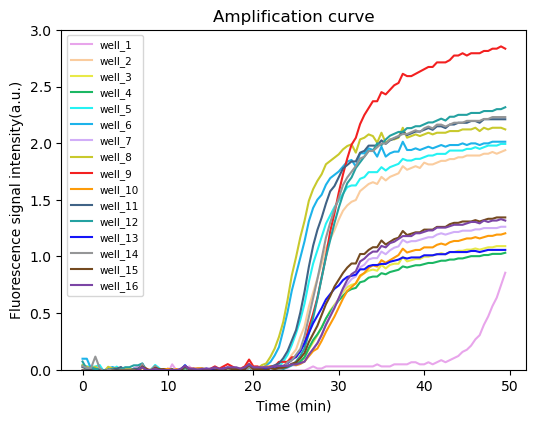

SystemExit: 0

C:\Users\danie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import sys
#from Sulink_Temperature_ver1 import *   #執行
from CT_Display1221 import *
# from Sulink_Temperature_20211217 import *   #執行

if __name__ == '__main__':
    app = QApplication(sys.argv)

    mainWindows = QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(mainWindows)
    mainWindows.show()
    sys.exit(app.exec_())